## Car Damage Severity Classification
### Autumn Mizer, Peter Kwaterski, Austin Koske

This notebook implements a deep learning model using InceptionV3 which is pretrained on ImageNet to classify car damage severity into minor, moderate, and severe. The dataset is made by Prajwal Bhamere and comes from https://www.kaggle.com/datasets/prajwalbhamere/car-damage-severity-dataset/data.

In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

The code segment below takes care of data processing and augmentation. The InceptionV3 model is trained for 299x299 RGB images, so the datasets images need to be scaled to work as intended with the base model. These augmentation settings were also found to be helpful for training accuracy for this dataset, and is also done to prevent overfitting. Only rescaling has been done to the validation data.

In [ ]:
img_size = (299,299) # inceptionv3 requires 299x299 rgb
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255
)

train = datagen.flow_from_directory(
    "../dataset/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

datagen = ImageDataGenerator(rescale=1./255)

val = datagen.flow_from_directory(
    "../dataset/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1383 images belonging to 3 classes.
Found 248 images belonging to 3 classes.


The code segment below contains the base model implementation of InceptionV3. It uses the pretrained ImageNet weights.

More information can be found here for the base model
https://keras.io/api/applications/inceptionv3/

In [33]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

#freeze layers in base model
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
preds = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4), #head training
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train,
    validation_data = val,
    epochs=15
)

Epoch 1/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.6016 - loss: 0.8386 - val_accuracy: 0.6815 - val_loss: 0.6690
Epoch 2/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9190 - loss: 0.2588 - val_accuracy: 0.6250 - val_loss: 0.9267
Epoch 3/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.9761 - loss: 0.0887 - val_accuracy: 0.6815 - val_loss: 0.8349
Epoch 4/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.9783 - loss: 0.0647 - val_accuracy: 0.6532 - val_loss: 1.1528
Epoch 5/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - accuracy: 0.9646 - loss: 0.1103 - val_accuracy: 0.7339 - val_loss: 0.8828
Epoch 6/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.9740 - loss: 0.0765 - val_accuracy: 0.6411 - val_loss: 1.1500
Epoch 7/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.9899 - loss: 0.0352 - val_accuracy: 0.6774 - val_loss: 1.1715
Epoch 8/15
44/44 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.9855 - loss: 0.0510 - val_accuracy: 0.6331 - v

Text(0.5, 1.0, 'Loss')

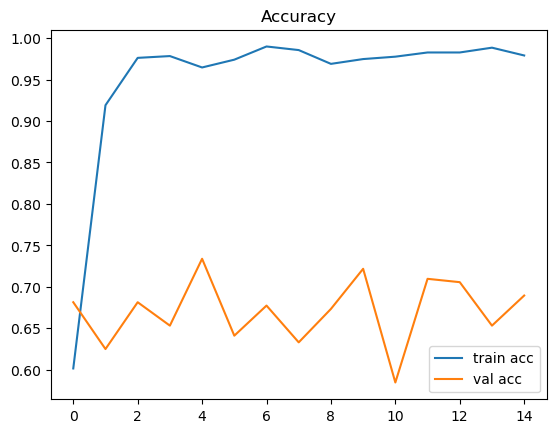

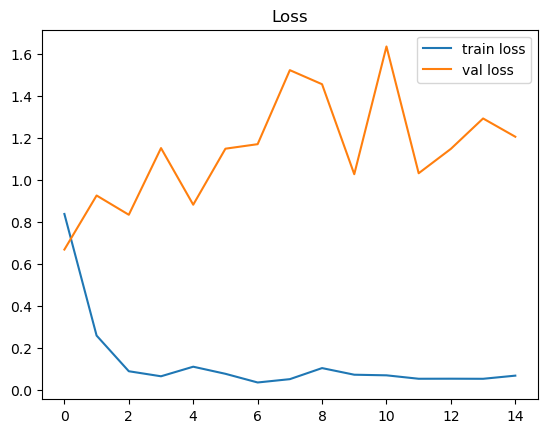

In [37]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 879ms/step


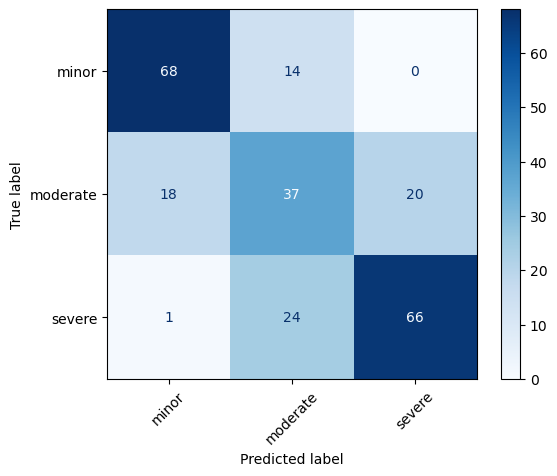

              precision    recall  f1-score   support

       minor       0.78      0.83      0.80        82
    moderate       0.49      0.49      0.49        75
      severe       0.77      0.73      0.75        91

    accuracy                           0.69       248
   macro avg       0.68      0.68      0.68       248
weighted avg       0.69      0.69      0.69       248



In [38]:
y_true = val.classes
y_pred = model.predict(val)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_labels)
labels = list(train.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()

print(classification_report(y_true, y_pred_labels, target_names=labels))

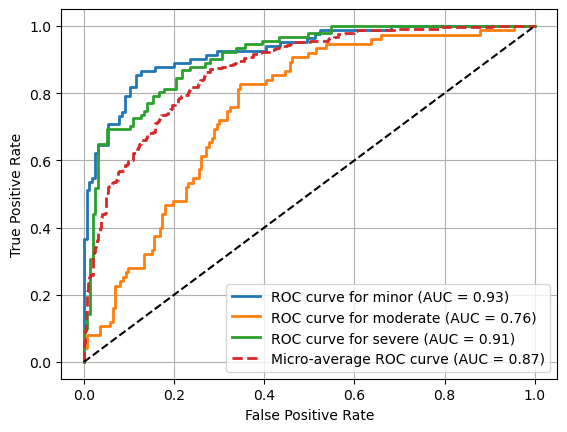

In [41]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

labels = list(train.class_indices.keys())
n_classes = len(labels)

y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label=f"ROC curve for {labels[i]} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
         linestyle='--', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


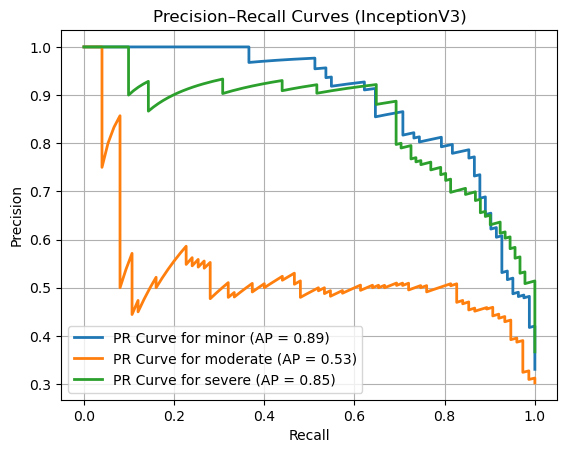

In [42]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

precision = {}
recall = {}
avg_precision = {}

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_pred[:, i])

    plt.plot(
        recall[i],
        precision[i],
        lw=2,
        label=f"PR Curve for {labels[i]} (AP = {avg_precision[i]:.2f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (InceptionV3)")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()
